In [1]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
# Input dari pengguna untuk simbol saham
symbol = input("Masukkan simbol saham (misalnya 'AAPL'): ")
start_date = date(2018, 1, 1)
end_date = date(2024, 2, 1)

# Mengunduh data saham dari Yahoo Finance # Menambahkan kolom tanggal sebagai indeks
data = yf.download(symbol, start=start_date, end=end_date)
data.reset_index(inplace=True)

# Input dari pengguna untuk fitur yang akan digunakan
input_feat = input("Masukkan fitur yang akan digunakan ('Adj Close','Close'): ")


data = data[["Date", input_feat]]# Memilih kolom tanggal dan fitur yang akan digunakan
data

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,2018-01-01,3309.033691
1,2018-01-02,3299.943115
2,2018-01-03,3281.761475
3,2018-01-04,3227.217041
4,2018-01-05,3263.580078
...,...,...
1510,2024-01-25,5525.000000
1511,2024-01-26,5425.000000
1512,2024-01-29,5575.000000
1513,2024-01-30,5625.000000


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

In [5]:
# Pembagian data menjadi data latih dan data uji
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]

In [6]:
# Persiapan Create Sequences LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

In [7]:
sequence_length = 1 
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [8]:
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, 1)))
# model.add(LSTM(64))
# model.add(Dense(1))
# model.summary()

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')         

In [9]:
cp3 = ModelCheckpoint('../model/model2/', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, callbacks=[cp3, early_stopping], validation_data=(X_test, y_test))

Epoch 1/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


38/38 - 17s - loss: 0.1239 - accuracy: 8.2576e-04 - val_loss: 0.1828 - val_accuracy: 0.0000e+00 - 17s/epoch - 453ms/step
Epoch 2/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


38/38 - 9s - loss: 0.0173 - accuracy: 8.2576e-04 - val_loss: 0.0915 - val_accuracy: 0.0033 - 9s/epoch - 246ms/step
Epoch 3/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


38/38 - 9s - loss: 0.0128 - accuracy: 8.2576e-04 - val_loss: 0.0486 - val_accuracy: 0.0033 - 9s/epoch - 248ms/step
Epoch 4/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


38/38 - 10s - loss: 0.0096 - accuracy: 8.2576e-04 - val_loss: 0.0171 - val_accuracy: 0.0033 - 10s/epoch - 250ms/step
Epoch 5/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


38/38 - 9s - loss: 0.0056 - accuracy: 8.2576e-04 - val_loss: 0.0017 - val_accuracy: 0.0033 - 9s/epoch - 250ms/step
Epoch 6/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


38/38 - 10s - loss: 0.0038 - accuracy: 8.2576e-04 - val_loss: 0.0011 - val_accuracy: 0.0033 - 10s/epoch - 252ms/step
Epoch 7/100
38/38 - 1s - loss: 0.0034 - accuracy: 8.2576e-04 - val_loss: 0.0055 - val_accuracy: 0.0033 - 591ms/epoch - 16ms/step
Epoch 8/100
38/38 - 1s - loss: 0.0030 - accuracy: 8.2576e-04 - val_loss: 0.0020 - val_accuracy: 0.0033 - 500ms/epoch - 13ms/step
Epoch 9/100
Restoring model weights from the end of the best epoch: 6.
38/38 - 1s - loss: 0.0030 - accuracy: 8.2576e-04 - val_loss: 0.0045 - val_accuracy: 0.0033 - 556ms/epoch - 15ms/step
Epoch 9: early stopping


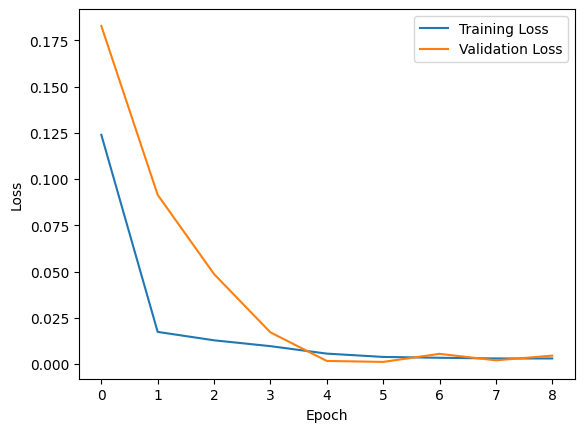

In [10]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

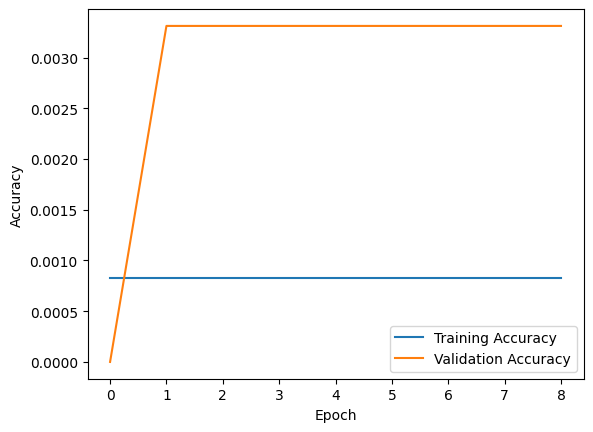

In [11]:
# Misalnya, jika Anda memiliki metrik akurasi:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
print("Loss di data uji:", loss)

print("Loss di data uji:", loss)
predict = model.predict(X_test)
# print(predict)

10/10 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 0.0033    
Loss di data uji: [0.0011195680126547813, 0.0033112582750618458]
Loss di data uji: [0.0011195680126547813, 0.0033112582750618458]
10/10 [==============================] - 1s 7ms/step


In [13]:

print("-"*50, " Metric ","-"*50)
print('RMSE : ',sqrt(metrics.mean_squared_error(y_test,predict)))
print('MSE  :  ',metrics.mean_squared_error(y_test,predict))
print('MAE  :  ',metrics.mean_absolute_error(y_test,predict))
print("-"*26, " Mengecek Apakah Nilainya Overfit atau tidak ","-"*26)


--------------------------------------------------  Metric  --------------------------------------------------
RMSE :  0.033459948572539006
MSE  :   0.001119568158476955
MAE  :   0.027406402776674905
--------------------------  Mengecek Apakah Nilainya Overfit atau tidak  --------------------------


In [14]:
# Simpan model
# model.save("../home-page-stock-prediction/lstm_model2.keras")
# print("Successfully saved model")

model.save("lstm_model2.keras")
print("Successfully saved model")

Successfully saved model
